In [3]:
import time
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import polars as pl
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

# container to keep adding results across runs
results = {}

3.10.7


# Method 1: Pandas dataframes

In [14]:
# Start timer
start_time = time.time()

df1 = pq.read_table("data.parquet").to_pandas()
df2 = pq.read_table("data_modified.parquet").to_pandas()

match_rate = (df1 == df2).all(axis=1).mean()
print(f"Row-level match rate: {match_rate:.10f}")

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Add entry under key 'Pandas'
results["Pandas"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}

print(results)

Row-level match rate: 0.9999714286
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 12.5961756706}}


# Method 2: Polars

In [15]:
# Start timer
start_time = time.time()

# Read Parquet files using Polars
df1 = pl.read_parquet("data.parquet")
df2 = pl.read_parquet("data_modified.parquet")

# Compute row-level match rate
# (df1 == df2) gives a Boolean DataFrame
# .row(eq=True) checks if all values in the row are True
match_rate = (df1 == df2).rows().count((True,) * df1.width) / df1.height

# Print result
print(f"Row-level match rate: {match_rate:.10f}")

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Add entry under key 'Polars'
results["Polars"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(elapsed_time, 10)
}

print(results)


Row-level match rate: 0.9999714286
{'Pandas': {'match_rate': 0.9999714286, 'time_taken_sec': 12.5961756706}, 'Polars': {'match_rate': 0.9999714286, 'time_taken_sec': 5.2714591026}}


# Method 3: Read parquet files directly

In [ ]:
path1 = "data.parquet"
path2 = "data_modified.parquet"
batch_size = 7_000_000  # tune as needed

num_runs = 5
times = []
match_rate = None  # to store final match rate (same across runs)

for _ in range(num_runs):
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    # Fast fail if total row counts differ
    if pf1.metadata.num_rows != pf2.metadata.num_rows:
        raise ValueError(f"Total row count mismatch: {pf1.metadata.num_rows} vs {pf2.metadata.num_rows}")

    total_rows = matched_rows = 0

    for b1, b2 in zip(pf1.iter_batches(batch_size=batch_size), pf2.iter_batches(batch_size=batch_size)):
        if b1.num_rows != b2.num_rows or b1.num_columns != b2.num_columns:
            raise ValueError("Batch shape mismatch")

        # Row-wise full equality: AND across all per-column equalities
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )

        # Count True values in this batch
        matches_in_batch = int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        matched_rows += matches_in_batch
        total_rows += b1.num_rows

    match_rate = matched_rows / total_rows if total_rows else 1.0
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

avg_time = sum(times) / num_runs

results["PyArrow"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(avg_time, 10)
}

print(f"Row-level match rate: {match_rate:.10f}")
print(f"Average time over {num_runs} runs: {avg_time:.6f} sec")
print(results)


Row-level match rate: 0.9999714286
Average time over 5 runs: 1.757054 sec
{'PyArrow': {'match_rate': 0.9999714286, 'time_taken_sec': 1.7570537567}}


# Method 4: Read parquet files directly with tuned batch processing

Batch size 10,000 → 2.1673 sec
Batch size 20,000 → 1.8223 sec
Batch size 30,000 → 1.6610 sec
Batch size 40,000 → 1.7009 sec
Batch size 50,000 → 1.6086 sec
Batch size 60,000 → 1.7936 sec
Batch size 70,000 → 1.6898 sec
Batch size 80,000 → 1.5688 sec
Batch size 90,000 → 1.6559 sec
Batch size 100,000 → 1.6986 sec
Batch size 110,000 → 1.6167 sec
Batch size 120,000 → 1.5471 sec
Batch size 130,000 → 1.6188 sec
Batch size 140,000 → 1.7180 sec
Batch size 150,000 → 1.5608 sec
Batch size 160,000 → 1.5785 sec
Batch size 170,000 → 1.6443 sec
Batch size 180,000 → 1.6820 sec
Batch size 190,000 → 1.6452 sec
Batch size 200,000 → 1.6331 sec
Batch size 210,000 → 1.7033 sec
Batch size 220,000 → 1.6073 sec
Batch size 230,000 → 1.5546 sec
Batch size 240,000 → 1.5732 sec
Batch size 250,000 → 1.9023 sec
Batch size 260,000 → 1.9491 sec
Batch size 270,000 → 1.5506 sec
Batch size 280,000 → 1.5253 sec
Batch size 290,000 → 1.6480 sec
Batch size 300,000 → 1.3983 sec

✅ Optimal batch size: 300,000 rows



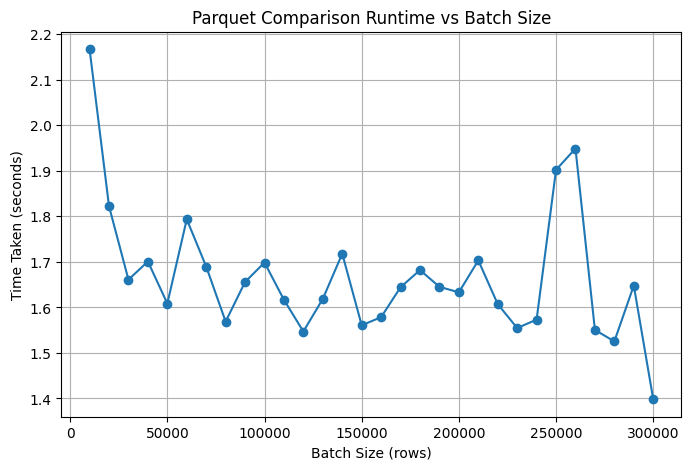

In [5]:
path1 = "data.parquet"
path2 = "data_modified.parquet"

# Testing different batch sizes
batch_sizes = list(range(10_000, 300_001, 10_000))  # 10k → 1M in 10k steps
batch_times = []

for bs in batch_sizes:
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    total_rows = matched_rows = 0
    for b1, b2 in zip(pf1.iter_batches(batch_size=bs), pf2.iter_batches(batch_size=bs)):
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )
        matched_rows += int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        total_rows += b1.num_rows

    elapsed_time = time.time() - start_time
    batch_times.append(elapsed_time)
    print(f"Batch size {bs:,} → {elapsed_time:.4f} sec")

# Find optimal batch size (min time)
optimal_batch_size = batch_sizes[batch_times.index(min(batch_times))]
print(f"\n✅ Optimal batch size: {optimal_batch_size:,} rows\n")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, batch_times, marker='o')
plt.title("Parquet Comparison Runtime vs Batch Size")
plt.xlabel("Batch Size (rows)")
plt.ylabel("Time Taken (seconds)")
plt.grid(True)
plt.show()

In [6]:
path1 = "data.parquet"
path2 = "data_modified.parquet"
batch_size = optimal_batch_size

num_runs = 5
times = []
match_rate = None  # to store final match rate (same across runs)

for _ in range(num_runs):
    start_time = time.time()

    pf1, pf2 = pq.ParquetFile(path1), pq.ParquetFile(path2)

    # Fast fail if total row counts differ
    if pf1.metadata.num_rows != pf2.metadata.num_rows:
        raise ValueError(f"Total row count mismatch: {pf1.metadata.num_rows} vs {pf2.metadata.num_rows}")

    total_rows = matched_rows = 0

    for b1, b2 in zip(pf1.iter_batches(batch_size=batch_size), pf2.iter_batches(batch_size=batch_size)):
        if b1.num_rows != b2.num_rows or b1.num_columns != b2.num_columns:
            raise ValueError("Batch shape mismatch")

        # Row-wise full equality: AND across all per-column equalities
        row_equal = reduce(
            pc.and_kleene,
            (pc.equal(b1.column(i), b2.column(i)) for i in range(b1.num_columns))
        )

        # Count True values in this batch
        matches_in_batch = int(pc.sum(pc.cast(row_equal, pa.int64())).as_py())
        matched_rows += matches_in_batch
        total_rows += b1.num_rows

    match_rate = matched_rows / total_rows if total_rows else 1.0
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

avg_time = sum(times) / num_runs

results["PyArrow (tuned batch size)"] = {
    "match_rate": round(match_rate, 10),
    "time_taken_sec": round(avg_time, 10)
}

print(f"Row-level match rate: {match_rate:.10f}")
print(f"Average time over {num_runs} runs: {avg_time:.6f} sec")
print(results)


Row-level match rate: 0.9999714286
Average time over 5 runs: 1.583524 sec
{'PyArrow (tuned batch size)': {'match_rate': 0.9999714286, 'time_taken_sec': 1.5835235119}}


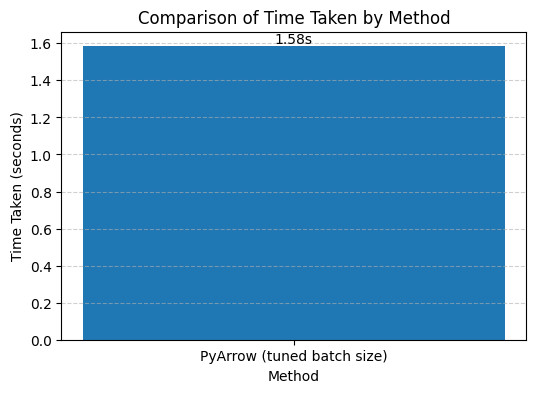

In [ ]:
# Visualise the results

# Extract methods and their corresponding times
methods = list(results.keys())
times = [v['time_taken_sec'] for v in results.values()]

# Plot bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, times)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}s", 
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Comparison of Time Taken by Method")
plt.xlabel("Reconciliation Method")
plt.ylabel("Time Taken (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
